In [1]:
### Tensile Test Analysis - Adaline Farrow 2024

# import stuff
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from scipy.optimize import *
from scipy.signal import *
from more_itertools import sliced
import math

## Functions (Only Change If Needed)

In [97]:
def readptb(folder, filename, length, width):
    # Set cwd based on provided directory
    os.chdir(folder)
    # Get data from the file
    df = np.array(pd.read_csv(filename))
    # Return calculated stress and strain values
    print(df[0,4])
    return df[:,5]/df[0,4], df[:,6]/(length*width)

def readSR(folder, filename, length, width):
    # Set cwd based on provided directory
    os.chdir(folder)
    # Get data from the file
    df = np.array(pd.read_csv(filename))
    # Return calculated time and stress values
    return df[:,2], df[:,6]/(length*width)

def plotSR(x, y, legend):
    x, y = list(x), list(y)        # Lists for indexing
    peak = max(y)                  # Find maximum stress
    peak_index = y.index(max(y))   # Find index of max stress
    eovere = peak/math.e           # Find e0/e
    yi = y.index(min(y, key=lambda y:abs(y - eovere))) # Find index of closest value to e0/e
    tau = x[yi]                    # Find relaxation time
    print('Relaxation Time: ', tau, 's')               # Print relaxation time
     
    # Plot data to 10x relaxation times
    plt.plot(x[:int(yi*10)], y[:int(yi*10)], 'g-', linewidth = 0.5)
    
    # Label axes
    plt.xlabel('Time (s)', size = 13)
    plt.ylabel('Stress ($\sigma$)', size = 13)
    
    # If selected, add relaxation time to legend
    if legend:
        plt.plot(0,0,'g,', label = r'$\tau$ = '+str(x[yi])+' s')
        plt.legend(loc='best', fontsize = 12)

def readcyc(folder, filename, length, width):
    # Set cwd based on provided directory
    os.chdir(folder)
    # Get data from the file
    df = np.array(pd.read_csv(filename))
    
    # Extract stretch/relax column for differentiation
    cycle = list(df[:,1])
    
    # Initialize lists for stretch_x, stretch_y, relax_x, relax_y data
    sx = []
    sy = []
    rx = []
    ry = []
        
    for i in range(len(cycle)):            # For every value in the cycle info column,
        if cycle[i] == '1-Stretch':        # If it's a stretch cycle, 
            sx.append(df[i,5]/df[0,4])     # Add stretching data and calculate stress and strain respectively
            sy.append(df[i,6]/(length*width))
        else:                              # If it isn't a stretch cycle,
            rx.append(df[i,5]/df[0,4])     # Do the same thing for relaxation data
            ry.append(df[i,6]/(length*width))
    
    # Split all stretch and relax lists into their respective cycles using cyc_split function
    dfsx = cyc_split(sx) # Definitely could have done this better but I was already about to cry
    dfsy = cyc_split(sy)
    dfrx = cyc_split(rx) # dfsx = data_frame_stretch_x, and so on
    dfry = cyc_split(ry)
    
    # 3D array :sob: contains all data in file
    dff = np.array([dfsx, dfsy, dfrx, dfry], dtype=object) # dff = data_frame_final
    
    return dff
    
def plotcyc(dff, plot_one_cycle):
    
    if plot_one_cycle[0]:  # If one cycle only,
        i = plot_one_cycle[1]  
        plt.plot(dff[0, i-1], dff[1, i-1], 'r-', linewidth = 0.5) # Plot the selected cycle
        plt.plot(dff[2, i-1], dff[3, i-1], 'b-', linewidth = 0.5)
    
    else:
        # Plot everything but also colour coordinated
        for i in range(len(dff[0, :])):
            plt.plot(dff[0, i], dff[1, i], 'r-', linewidth = 0.5)
            plt.plot(dff[2, i], dff[3, i], 'b-', linewidth = 0.5)

    # Do a little cheating for a nice legend (only one line each instead of one for each cycle)
    plt.plot(0, 0, 'r-', linewidth = 0.5, label = 'Stretching')
    plt.plot(0, 0, 'b-', linewidth = 0.5, label = 'Relaxation')
    
    # Label axes, create legend
    plt.xlabel('Strain ($\epsilon$)', size = 13)
    plt.ylabel('Stress ($\sigma$)', size = 13)
    
    plt.legend(loc = 'best', fontsize = 12)
    
def plotonecyc(dff, i):
    # Plot everything but also colour coordinated
    plt.plot(dff[0, i-1], dff[1, i-1], 'r-', linewidth = 0.5)
    plt.plot(dff[2, i-1], dff[3, i-1], 'b-', linewidth = 0.5)
    
    # Do a little cheating for a nice legend (only one line each instead of one for each cycle)
    plt.plot(0, 0, 'r-', linewidth = 0.5, label = 'Stretching')
    plt.plot(0, 0, 'b-', linewidth = 0.5, label = 'Relaxation')
    
    # Label axes, create legend
    plt.xlabel('Strain ($\epsilon$)', size = 13)
    plt.ylabel('Stress ($\sigma$)', size = 13)
    
    plt.legend(loc = 'best', fontsize = 12)
    
def cyc_split(l):
    # I stole this code I don't actually know how it does it but I made it split a list based on discontinuities 
    # present in cycle resets provided the discontinuity is greater than 0.1
    # it works that is all I need
    result = []
    temp_list = []
    for i in range(len(l)-1):
        if np.abs(l[i+1] - l[i]) > 0.1:
            temp_list.append(l[i])
            result.append(temp_list)
            temp_list = []
        else:
            temp_list.append(l[i])
    result.append(temp_list)
    return (result)

def hyst(dff, one_cycle, legend):
    if one_cycle[0]:       # If only one cycle,
        i = one_cycle[1]   # Calculate and print hysteresis
        h = np.round(((np.trapz(dff[1, i-1], dx = 0.001) - np.trapz(dff[3, i-1], dx = 0.001))/(np.trapz(dff[1, i-1], dx = 0.001)))*100, 2)
        print((np.trapz(dff[1, i-1], dx = 0.001),  np.trapz(dff[3, i-1], dx = 0.001), (np.trapz(dff[1, i-1], dx = 0.001))))
        print(f'Hysteresis for cycle {i}: {h}%')
        
        if legend: # If selected, add hysteresis to legend
            plt.plot(0, 0, 'r,', label = f'H$_{i}$: {h}%')
            plt.legend(loc='best')
    
    else:
        for i in range(len(dff[0, :])): # Calculate and print all hystereses
            h = np.round(((np.trapz(dff[1, i], dx = 0.001) - np.trapz(dff[3, i], dx = 0.001))/(np.trapz(dff[1, i], dx = 0.001)))*100, 2)
            print(f'Hysteresis for cycle {i}: {h}%')
            
            if legend:
                plt.plot(0, 0, 'r,', label = f'H$_{i}$: {h}%')
                plt.legend(loc='best')

def plotptb(x, y, legend):
    # Convert x, y to lists because indexing arrays is annoying
    x = list(x)
    y = list(y)
    
    # Plot truncated data (400 datapoints after break)
    plt.plot(x[:y.index(max(y))+400], y[:y.index(max(y))+400], 'r-', linewidth = 0.5)
    
    # If legend is True, add max stress and strain to legend
    if legend:
        plt.plot(x[y.index(max(y))], y[y.index(max(y))], 'r,', marker='None', label = f'Max. Stress: {np.round(max(y),2)} MPa')
        plt.plot(x[y.index(max(y))], y[y.index(max(y))], 'r,', marker='None', label = f'Max. Strain: {np.round(x[y.index(max(y))]*100, 2)} %')

        plt.legend(loc='best', fontsize = 12)
        
    # Label axes, create legend
    plt.xlabel('Strain (%)', size = 13)
    plt.ylabel('Stress (MPa)', size = 13)
    
    # Print calculated values
    print('Max Stress:', np.round(max(y),4), 'MPa')
    print(f'Max. Strain: {np.round(x[y.index(max(y))],4)*100} %')
    
def tough(x, y, legend):
    # Calculate and print toughness value by integrating the area under the curve
    print('Toughness:', np.round(np.trapz(y, x, dx = 0.01), 3), 'MJ/m3')
    
    # If selected, add toughness to plot
    if legend:
        plt.plot(0,0,'r,', label = f'Toughness: {np.round(np.trapz(y, x, dx = 0.01), 3)} MJ/m$^3$')
        
        plt.legend(loc = 'best')
    
def mod(x, y, domain, plot_slope):
    # Convert to lists for indexing
    x = list(x)
    y = list(y)
    
    # Find the values in the list closest to the specified domain
    x0 = x.index(min(x, key=lambda x:abs(x-domain[0])))
    x1 = x.index(min(x, key=lambda x:abs(x-domain[1])))
    
    # Calculate the slope/modulus on the specified range
    m = np.round((y[x1]-y[x0])/(x[x1]-x[x0]), 4)
    
    # Print modulus
    print(f'Young\'s modulus on [{np.round(x[x0],2)}, {np.round(x[x1],2)}]:', m)
    x = np.array(x)
    if plot_slope: # If selected, add slope to plot
        plt.plot(x[x0:x1], m*x[x0:x1], 'k--', linewidth = 1, label = f'E on [{np.round(x[x0],2)}, {np.round(x[x1],2)}]: {m} MPa')
    
        plt.legend(loc = 'upper left', fontsize = 9)
    
def save(folder, filename):
    os.chdir(folder)
    plt.savefig(filename+'.png', dpi=500)

## Pull To Break

4.966
Max Stress: 45.1348 MPa
Max. Strain: 18.060000000000002 %
Toughness: 5.897 MJ/m3
Young's modulus on [0.06, 0.08]: 542.2738


C:\Users\ajfar\AppData\Local\Temp\ipykernel_19364\3088142758.py:157: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r," (-> marker=','). The keyword argument will take precedence.
  plt.plot(x[y.index(max(y))], y[y.index(max(y))], 'r,', marker='None', label = f'Max. Stress: {np.round(max(y),2)} MPa')
C:\Users\ajfar\AppData\Local\Temp\ipykernel_19364\3088142758.py:158: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r," (-> marker=','). The keyword argument will take precedence.
  plt.plot(x[y.index(max(y))], y[y.index(max(y))], 'r,', marker='None', label = f'Max. Strain: {np.round(x[y.index(max(y))]*100, 2)} %')


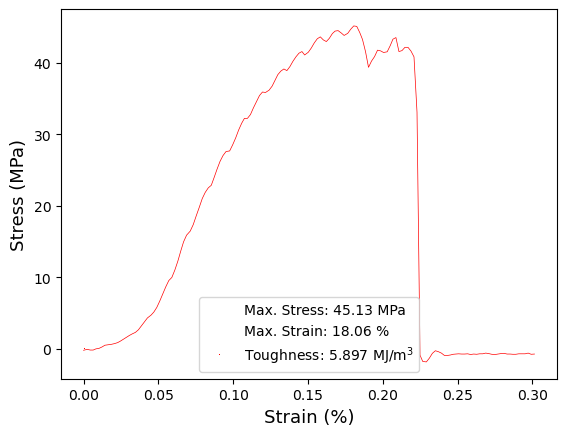

In [101]:
"""
Func: readptb
Input: (file directory:str, filename:str, x_param_of_sample:float, y_param_of_sample:float)
Output: None
Returns: strain values:list, stress values:list
"""
strain, stress = readptb('C:/Users/ajfar/Desktop/McGill/Research/Harrington_Singh_2024/Tensile/2024-06-27_Fiber_PTB'
                         , 'Ca_E56_PTB001Data.csv', 0.078, 0.078)

###########################################################################################################################
"""
Func: plotptb
Input: (strain values:list, stress values:list, legend:bool)
Output: Plot containing truncated data, print calculated max stress, strain. IF legend True, add values to legend
Returns: None
"""
plotptb(strain, stress, legend=True)

###########################################################################################################################
"""
Func: tough
Input: (strain values:list, stress values:list, legend:bool)
Output: Print calculated toughness. Adds calculated toughness value to graph and legend IF legend=True
Returns: None
"""
tough(strain, stress, legend=True)

###########################################################################################################################
"""
Func: mod - CALCULATE AS MANY MODULI AS YOU WANT OVER ANY DOMAIN
Input: (strain values:list, stress values:list, domain[float, float], plot_slope:bool)
Output: Print caluclated Young's Modulus over specified domain. If plot_slope = True, add value to legend, 
        plot slope on graph
Returns: None
"""
mod(strain, stress, domain=[0.06, 0.08], plot_slope=False)

###########################################################################################################################
"""
Func: save
Input: (Directory:str, Desired Filename:str) - WILL ADD .png AUTOMATICALLY
Output: High-res png to prespecified folder
Returns: None
"""
save('C:/Users/ajfar/Desktop/McGill/Research/Harrington_Singh_2024/Tensile/2024-06-27_Fiber_PTB/plots'
     , '1_001.png')

#### Cyclic Loading

Hysteresis for cycle 0: 77.95%
Hysteresis for cycle 1: 53.99%
Hysteresis for cycle 2: 43.78%


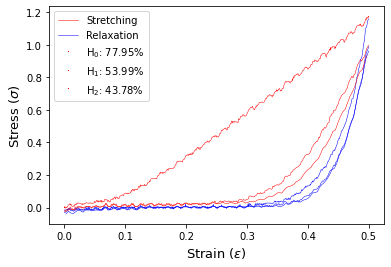

In [4]:
"""
Func: readcyc
Input: (file directory:str, filename:str, x_param_of_sample in mm:float, y_param_of_sample in mm:float)
Output: None
Returns: final dataframe:array (code is written to read this, it's explained in functions)
"""
data = readcyc('C:/Users/ajfar/Desktop/McGill/Research/Harrington_Singh_2024/Tensile', 'cyclicrate_007Data.csv', 2, 2)

###########################################################################################################################
"""
Func: plotcyc
Input: (dataframe:array, plot_one_cycle(bool, int))
Output: plot of all cycles OR plot one single specified cycle
Returns: None
"""
plotcyc(data, plot_one_cycle=(False, 3))

###########################################################################################################################
"""
Func: hyst
Input: (dataframe:array, one_cycle(bool, int), legend:bool)
Output: Calculate and print hysteresis of all cycles OR one single specified cycle, add value(s) to legend if True
Returns: None
"""
hyst(data, one_cycle=(False, 3), legend = True)

save('C:/Users/ajfar/Desktop/McGill/Research/Harrington_Singh_2024/Tensile', 'cyclicrate_007plot')

## Stress - Relaxation

Relaxation Time:  4.66 s


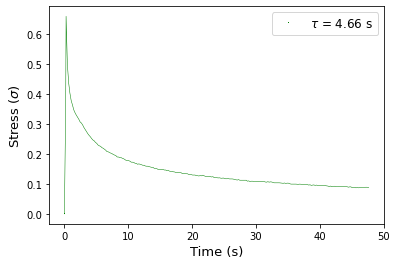

In [5]:
"""
Func: readSR
Input: (file directory:str, filename:str, x_param_of_sample in mm:float, y_param_of_sample in mm:float)
Output: None
Returns: time values:list, stress values:list
"""
time, stress = readSR('C:/Users/ajfar/Desktop/McGill/Research/Harrington_Singh_2024/Tensile', 'relaxCf_009Data.csv', 2, 2)

###########################################################################################################################
"""
Func: plotSR
Input: (time:list, stress:list, legend:bool)
Output: plot of stress relaxation curve, prints relaxation time
Returns: None
"""
plotSR(time, stress, legend=True)

###########################################################################################################################
save('C:/Users/ajfar/Desktop/McGill/Research/Harrington_Singh_2024/Tensile', 'relaxCf_009Data')